This notebook is a generative chemistry workflow using SAFE encodings and subsequent compound ranking according to the shape/ESP similarity of an existing ligand conformation.

The inspiration for this workflow can be found here:<br>
https://moleculeinsight.com/generative-chemistry-for-everyone-a-hands-on-guide-using-safe-encodings/

The code here has been modified to use RDkit O3A for conformer generation which seems to improve the conformational search space for ligands with more than 3-4 rotatable bonds. 


In [ ]:
!pip install -q safe-mol rdkit pandas py3Dmol datamol tqdm mols2grid useful_rdkit_utils
!pip install git+https://github.com/hesther/espsim

In [1]:
import py3Dmol
from espsim import GetEspSim, GetShapeSim
from rdkit import Chem
from rdkit.Chem import rdMolAlign, PandasTools, Crippen, AllChem, Draw, rdMolDescriptors
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import IPythonConsole
from copy import deepcopy
from itertools import chain
import numpy as np
import pandas as pd
import mols2grid
from tqdm import tqdm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import safe as sf
import datamol as dm
from openbabel import openbabel

tqdm.pandas()
PandasTools.RenderImagesInAllDataFrames(images=True)

def pdb_to_sdf_RDkit(pdb_file:str):
    #Convert pdb file to mol
    mol = Chem.MolFromPDBFile(pdb_file, removeHs=False)

    # Write to SDF
    sdf_file = pdb_file[:-4]+".sdf"
    writer = Chem.SDWriter(sdf_file)
    writer.write(mol)
    writer.close()

def pdb_to_sdf_OB(pdb_file:str):
    # Create a conversion object
    conv = openbabel.OBConversion()
    conv.SetInAndOutFormats("pdb", "sdf")

    # Read the PDB file
    mol = openbabel.OBMol()
    conv.ReadFile(mol, pdb_file)

    # Write the SDF file
    sdf_file = pdb_file[:-4]+".sdf"
    conv.WriteFile(mol, sdf_file)

def pdb_to_smiles(pdb_file:str):
    #Convert pdb file to mol
    mol = Chem.MolFromPDBFile(pdb_file, removeHs=False)

    #Convert mol to smiles
    smiles = Chem.MolToSmiles(mol)
    return(smiles)

def draw(mol, confId=0, width=400, height=400, background_color='white'):
    """
    Draws the 3D structure of a molecule using py3Dmol.

    Parameters:
        mol: The molecule to draw, RDKit Mol object.
        confId: The conformer ID to use for drawing. Defaults to 0.
        width: The width of the viewer window. Defaults to 400.
        height: The height of the viewer window. Defaults to 400.
        background_color: The background color of the viewer. Defaults to 'white'.

    Returns:
        The py3Dmol viewer with the molecule displayed.
    """

    if not isinstance(mol, Chem.Mol):
        raise TypeError("The provided mol parameter is not an RDKit Mol object.")

    view = py3Dmol.view(width=width, height=height)
    view.removeAllModels()
    
    try:
        mol_block = Chem.MolToMolBlock(mol, confId=confId)
    except Exception as e:
        raise RuntimeError(f"Failed to convert molecule to MolBlock: {e}")
    
    view.addModel(mol_block, 'sdf')
    view.setStyle({'model': confId}, {'stick': {'radius': 0.15}})
    view.setBackgroundColor(background_color)
    view.zoomTo()

    return view.show()

Convert a pdb file to sdf (For use as a reference ligand)

In [2]:
pdb_path = 'sirt6_ligand.pdb'
sdf_path = pdb_path[:-4]+".sdf"

# This approach does not produce smiles with the correct bond orders 
## ligand_smiles = pdb_to_smiles(pdb_path)

# For now specify the ligand smiles implicitly
ligand_smiles = 'CCCNC([C@H](CNC(CN(C=C(C(N)=O)C(N1)=O)C1=O)=O)NC(CCc1nc(-c2cnccc2)n[o]1)=O)=O'

# Using the OB conversion function 
# (pdb_to_sdf_RDkit works fine too, ive left both function for future reference) 
pdb_to_sdf_OB(pdb_path) 

Create 3D ligand in RDkit using the converted sdf file from above

In [3]:
suppl = Chem.SDMolSupplier('sirt6_ligand.sdf')
main_ligand = next(suppl)
ligand = Chem.AddHs(main_ligand, addCoords=True)
template = Chem.MolFromSmiles(ligand_smiles)
ligand = AllChem.AssignBondOrdersFromTemplate(template, ligand)
draw(ligand)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Specify the smiles fragments for use in SAFE

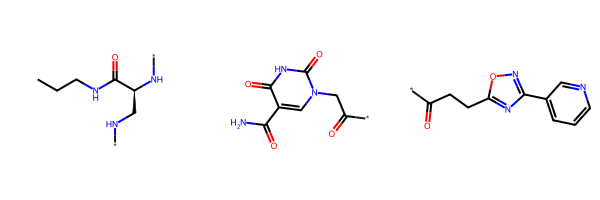

In [4]:
core = "CCCNC([C@@H](N[*])CN[*])=O"
frag_A = "O=C([*])CN1C=C(C(NC1=O)=O)C(N)=O"
frag_B = "O=C([*])CCC1=NC(C2=CC=CN=C2)=NO1"

frag_mols = [Chem.MolFromSmiles(smi) for smi in [core,frag_A,frag_B]]
Draw.MolsToGridImage(frag_mols, molsPerRow=3)

Initialize the required SAFE elements

/home/bill/anaconda3/envs/espsim/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


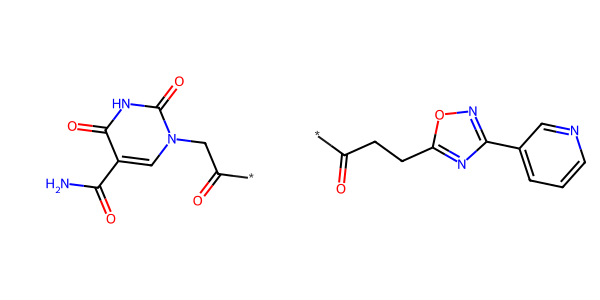

In [5]:
designer = sf.SAFEDesign.load_default(verbose=True)

# define the non-linker elements (side chains)
fragments = f"{frag_A}.{frag_B}"
linker_generation = [frag_A, frag_B]

# Show the side chain fragments with datamol
dm.to_image(linker_generation)

Generate new smiles with SAFE 

In [6]:

# Use safe to generate diffrent linkers
linker_variants = designer.linker_generation(
    *linker_generation,
    n_samples_per_trial=250,
    n_trials=4,
    sanitize=True,
    do_not_fragment_further=True,
    random_seed=100,
)

# Use safe to generate diffrent side chains
linker_mutants = designer.scaffold_morphing(
    side_chains=fragments,
    n_samples_per_trial=250,
    n_trials=4,
    sanitize=True,
    do_not_fragment_further=True,
    random_seed=100,
)

  0%|          | 0/4 [00:00<?, ?it/s]

/home/bill/anaconda3/envs/espsim/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
[16:09:46] WARNING: not removing hydrogen atom without neighbors
2024-08-03 16:09:47.074 | INFO     | safe.sample:_fragment_linking:408 - After sanitization, 850 / 1000 (85.00 %)  generated molecules are valid !


  0%|          | 0/4 [00:00<?, ?it/s]

[16:10:39] 

****
Range Error
idx
Violation occurred on line 218 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/ROMol.cpp
Failed Expression: 16 < 16
----------
Stacktrace:
----------
****

[16:11:07] Can't kekulize mol.  Unkekulized atoms: 15 17 18 24 25 26 27
[16:11:39] WARNING: not removing hydrogen atom without neighbors
2024-08-03 16:11:40.729 | INFO     | safe.sample:_fragment_linking:408 - After sanitization, 504 / 1000 (50.40 %)  generated molecules are valid !


Preview the generated linker variants

Generated 850 linker variants


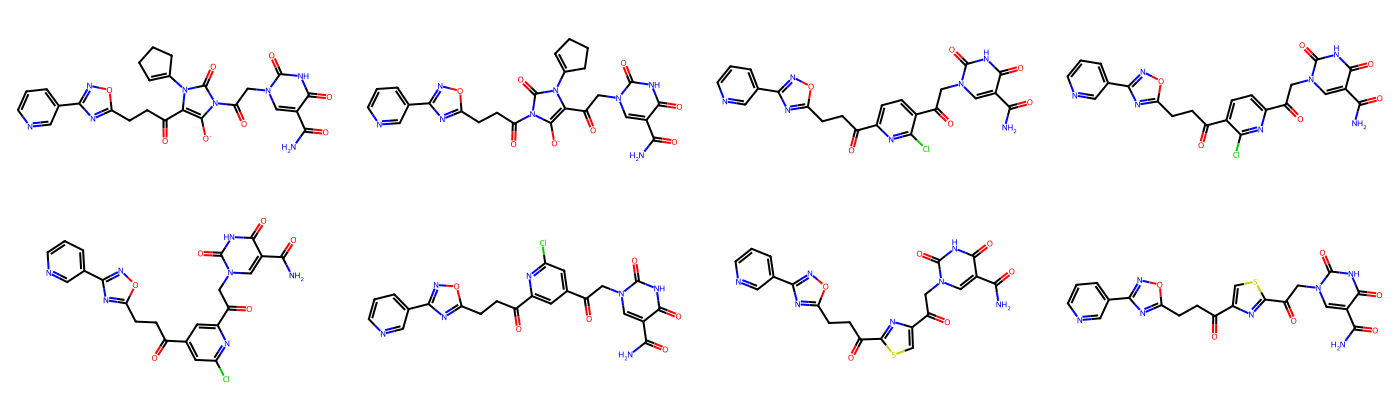

In [15]:
print(f'Generated {len(linker_variants)} linker variants')
dm.to_image(linker_variants[:8], mol_size=(350, 200))

Preview the generated linker mutants

Generated 504 linker variants


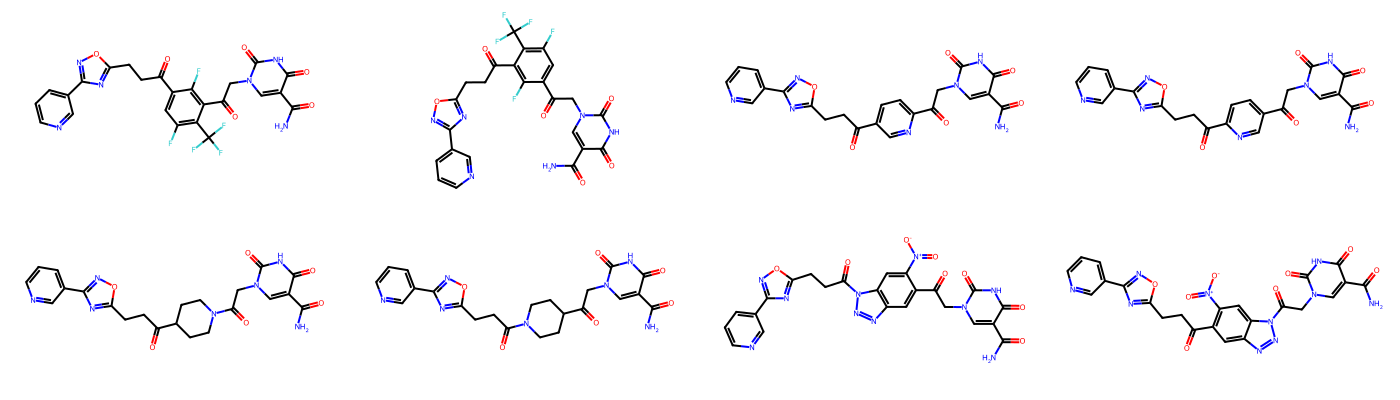

In [16]:
print(f'Generated {len(linker_mutants)} linker variants')
dm.to_image(linker_mutants[:8], mol_size=(350, 200))

Aggregate the generated variants

In [9]:
variant_smiles =linker_variants + linker_mutants
variant_smiles.append(ligand_smiles) #add original compound as a control 
print(f'Total generated smiles: {len(variant_smiles)-1}')

Total generated smiles: 1354


Create a process the main df with the variant smiles

In [10]:
main_df = pd.DataFrame({'smiles': variant_smiles})
print(f'Total compounds before removing duplicates: {len(main_df)}')

#Add mols to the df
PandasTools.AddMoleculeColumnToFrame(main_df,'smiles','molecule')

# Calc and add properties for later filtering 
main_df['rot_bonds'] = main_df.molecule.apply(rdMolDescriptors.CalcNumRotatableBonds)
main_df['logP'] = main_df.molecule.apply(Crippen.MolLogP)
main_df['HBD'] = main_df.molecule.apply(rdMolDescriptors.CalcNumHBD)
main_df['mw'] = main_df.molecule.apply(rdMolDescriptors.CalcExactMolWt)
main_df['inchi'] = main_df.molecule.apply((Chem.MolToInchiKey))

# Remove duplicates based on InchiKey
main_df.drop_duplicates(subset='inchi', inplace=True)
print(f'Total compounds after removing duplicates: {len(main_df)}')

Total compounds before removing duplicates: 1355
Total compounds after removing duplicates: 709


Survey the generated molecules for potentially problematic functional groups

In [11]:
reos = uru.REOS()
reos.set_active_rule_sets(["Dundee"])
main_df[['rule_set','reos']] = [list(reos.process_mol(x)) for x in main_df.molecule]
uru.value_counts_df(main_df,"reos")

,reos,count
0,ok,573
1,beta-keto/anhydride,24
2,imine,12
3,quaternary nitrogen,8
4,nitro group,8
5,phosphor,8
6,2-halo pyridine,8
7,thioester,6
8,phenol ester,6
9,diketo group,6


Perform Lipinski filter to produce a filtered df

In [12]:
filtered_df = main_df[
    (main_df['rot_bonds']<10) &
    (main_df['logP']<=5) &
    (main_df['HBD']<= 3) &
    (main_df['mw']<=600) &
    (main_df['reos']=='ok')
]
print (f'Remaining compounds after Lipinski filter: {len(filtered_df)}')

Remaining compounds after Lipinski filter: 464


Survey the filtered df for the most commonly occuring ring systems

In [13]:
ring_system_finder = uru.RingSystemFinder()
filtered_df = filtered_df.copy()
filtered_df['ring_systems'] = filtered_df.molecule.apply(ring_system_finder.find_ring_systems)
ring_list = chain(*filtered_df.ring_systems.values)
ring_series = pd.Series(ring_list)
ring_series.value_counts()
ring_df = pd.DataFrame(ring_series.value_counts()).reset_index()
ring_df.columns = ["SMILES","Count"]
mols2grid.display(ring_df,smiles_col="SMILES",subset=["img","Count"],selection=False)

MolGridWidget()

Display the filtered df mols 

In [14]:
mols2grid.display(filtered_df,
                  smiles_col="smiles",
                  selection=False,
                  size=(300, 150))

MolGridWidget()

Define the functions used for conformer search/alignment operations

In [24]:
class Conformer:
    '''A class for generating molecule conformers.'''
    def __init__(self, smiles, n_confs):
        # Define the conformer generator
        p = AllChem.ETKDGv3() 
        p.randomSeed = 0xf00d
        
        # Create molecule and add hydrogens
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        
        # Generate conformers
        conformer_ids = AllChem.EmbedMultipleConfs(mol, n_confs, p)
        
        # Get MMFF properties for the molecule
        mmff = AllChem.MMFFGetMoleculeProperties(mol)

        self.mol = mol
        self.mmff = mmff
        self.conformer_ids = conformer_ids

def isolate_conformer(mol, conf_id:int):
    """
    Retrives a specific conformer from a mol and returns it as an individual mol conformer.
    
    Parameters:
        mol (Mol): RDKit Mol object with embedded conformers.
        conf_id (int): The id corresponding to the desired conformer to return.
        
    Returns:
        new_mol (Mol): RDKit Mol object for the specied conf_id.
    """
    conformer = mol.GetConformer(conf_id)

    # Create a new molecule and add the conformer's coordinates
    new_mol = Chem.Mol(mol)
    new_conformer = Chem.Conformer(mol.GetNumAtoms())
    new_conformer.SetId(0)  # Set the ID of the new conformer
    for atom_idx in range(mol.GetNumAtoms()):
        pos = conformer.GetAtomPosition(atom_idx)
        new_conformer.SetAtomPosition(atom_idx, pos)

    # Replace the new molecule's conformer with the extracted conformer
    new_mol.RemoveAllConformers()
    new_mol.AddConformer(new_conformer)
    return new_mol

def get_esp_similarity_score(query_smi:str, ref_mol):
    """
    Calculates espsim similarity score data for an input smiles string with a reference mol.
    
    Parameters:
        query_smi (string): The smiles string to use for scoring. 
        ref_mol (Mol): Reference molecule (RDKit Mol object).
        
    Returns:
        best_conf (Mol): RDKit Mol object for the closest aligned conformer to the reference mol.
        shape_sim (float): The shape similarity score.
        esp_sim (float): The esp similarity score. 
        total_sim (float): The total (combined) score. 
    """
    # Generate conformers for the query smiles
    query_confs = Conformer(query_smi, 50)
    ref_mmff = AllChem.MMFFGetMoleculeProperties(ref_mol)
    conf_scores = []
    conf_ids = []
    mol_confs = [conf.GetId() for conf in query_confs.mol.GetConformers()]
    
    # Align and score conformers using the reference mol 
    for conf_id in mol_confs:
        O3A = rdMolAlign.GetO3A(query_confs.mol, ref_mol, query_confs.mmff, ref_mmff, conf_id, 0)
        O3A.Align()
        conf_scores.append(O3A.Score())
        conf_ids.append(conf_id)
    
    # Create a new mol for the best scoring conformation
    best_conf_id = int(np.argmax(conf_scores))
    best_conf = isolate_conformer(query_confs.mol, best_conf_id)

    # Calculate espsim similarity
    shape_sim = GetShapeSim(query_confs.mol, ref_mol, prbCid=best_conf_id, refCid=0)
    esp_sim = GetEspSim(query_confs.mol, ref_mol, prbCid=best_conf_id, refCid=0)
    total_sim = shape_sim + esp_sim
    
    return best_conf, shape_sim, esp_sim, total_sim

def generate_espsim_df(df, ref_mol):
    """
    Calculates and collects espsim score data for mols in dataframe with a reference mol.
    
    Parameters:
        df (DataFrame): DataFrame containing the smiles for scoring. Assumes a column 'smiles' with smiles strings.
        ref_mol (Mol): Reference molecule (RDKit Mol object).
        
    Returns:
        espsim df (DataFrame): A dataframe containing conformer mols, shape similarity scores, esp similarity scores, and total similarity scores.
    """
    sim_data = []
    for smi in df.smiles:
        best_conf, shape_sim, esp_sim, total_sim = get_esp_similarity_score(smi, ref_mol)
        sim_series = pd.Series({'conformer_mol':best_conf, 'shape_sim':shape_sim,  'esp_sim': esp_sim, 'total_sim':total_sim})
        sim_data.append(sim_series)
    espsim_df = pd.concat(sim_data, axis=1).T.reset_index(drop=True)
    return espsim_df

def draw_overlays(ref_mol, df, width=1000, height=2000, grid_size=(6, 3)):
    """
    Draws the superimposed 3D structures of a probe molecule and a reference molecule using py3Dmol.
    
    Parameters:
        ref_mol (Mol): Reference molecule (RDKit Mol object).
        df (DataFrame): DataFrame containing probe molecules. Assumes a column 'conformer_mol' with RDKit Mol objects.
        width (int): Width of the py3Dmol viewer.
        height (int): Height of the py3Dmol viewer.
        grid_size (tuple): Grid size for displaying molecules.
        
    Returns:
        py3Dmol.view: The py3Dmol viewer with the superimposed molecules displayed.
    """
    view = py3Dmol.view(width=width, height=height, linked=False, viewergrid=grid_size)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            mol_position_on_df = i * grid_size[1] + j
            
            # Check if the index is within the bounds of the DataFrame
            if mol_position_on_df >= len(df):
                continue

            # Extract the conformer molecule
            prbMol = deepcopy(df.iloc[mol_position_on_df]['conformer_mol'])
            
            # Add the probe and reference molecules to the viewer
            view.addModel(Chem.MolToMolBlock(prbMol), 'mol', viewer=(i, j))
            view.addModel(Chem.MolToMolBlock(ref_mol), 'mol', viewer=(i, j))
            
            # Set styles for the viewer
            view.setStyle({'stick': {}}, viewer=(i, j))
            view.setStyle({'model': 0}, {'stick': {'colorscheme': 'greenCarbon'}}, viewer=(i, j))
    
    view.zoomTo()
    return view.render()

Create a subset of the filtered df that will be used for conformational similarity analysis 

,smiles,molecule,rot_bonds,logP,HBD,mw,inchi,rule_set,reos,ring_systems
0,NC(=O)c1cn(CC(=O)n2c([O-])c(C(=O)CCc3nc(-c4ccc...,,9,-0.7020,2,561.148783,FGBXKBBYTNXXPO-UHFFFAOYSA-M,ok,ok,"[O=c1cc[nH]c(=O)[nH]1, O=c1[nH]cc[nH]1, c1ncon..."
1,NC(=O)c1cn(CC(=O)c2c([O-])n(C(=O)CCc3nc(-c4ccc...,,9,-0.7020,2,561.148783,POXUVKCAMIEEFW-UHFFFAOYSA-M,ok,ok,"[O=c1cc[nH]c(=O)[nH]1, O=c1[nH]cc[nH]1, c1ncon..."
2,NC(=O)c1cn(CC(=O)c2csc(C(=O)CCc3nc(-c4cccnc4)n...,,9,0.2354,2,481.080452,LQMQAAVGNWXSQE-UHFFFAOYSA-N,ok,ok,"[O=c1cc[nH]c(=O)[nH]1, c1cscn1, c1ncon1, c1ccn..."

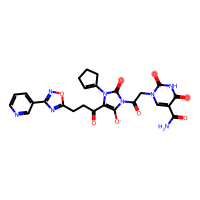
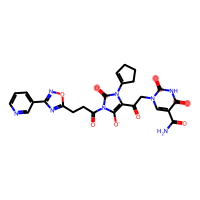
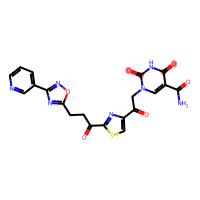

In [18]:
filtered_df = filtered_df.copy()
pruned_df = filtered_df.sample(200)
pruned_df = pruned_df.reset_index(drop=True)

pruned_df.head(3)

Calculate alignments and similarities as a seperate dataframe

In [48]:
espsim_df = generate_espsim_df(pruned_df, ligand)
espsim_df.sort_values(by='total_sim', ascending=False, inplace=True, ignore_index=True)
espsim_df.head()

KeyboardInterrupt: 

Show the first 24 overlays for inspection

In [47]:
draw_overlays(ligand, espsim_df)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.